In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 10)

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataPath = os.getcwd() + '/../data/atvi.csv'
data = pd.read_csv(dataPath)
data.index = pd.DatetimeIndex(pd.to_datetime(data['timestamp'], format='%Y-%m-%d %H:%M:%S'))
data.drop('timestamp', axis=1, inplace=True)

In [3]:
data['acc_volume'] = data.groupby(data.index.date)['volume'].cumsum()
data['acc_perc'] = data.groupby(data.index.date)['acc_volume'].transform(lambda x: x/x.iloc[-1])

start_of_day = (9 * 60) + 30
data[ 'minute_bars' ] = (data.index.hour * 60) + data.index.minute - start_of_day

In [4]:
data.head()

,open,high,low,close,volume,acc_volume,acc_perc,minute_bars
timestamp,,,,,,,,
2019-09-24 09:31:00,54.60,54.6000,54.5000,54.5000,83658,83658,0.013098,1
2019-09-24 09:32:00,54.29,54.2900,54.2900,54.2900,81132,164790,0.025800,2
2019-09-24 09:33:00,54.26,54.3645,54.2600,54.3645,7523,172313,0.026978,3
2019-09-24 09:34:00,54.28,54.3100,54.2101,54.2101,22693,195006,0.030531,4
2019-09-24 09:35:00,54.19,54.2700,54.1900,54.2600,24524,219530,0.034370,5


### Train Linear Regression

In [5]:
modelLR = Pipeline([
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('linear', LinearRegression(fit_intercept=False))
])
modelLR = modelLR.fit(data[['minute_bars']], data[['acc_perc']])
modelLR.named_steps['linear'].coef_

array([[ 5.37368687e-03, -2.91686022e-05,  7.21057741e-08,
        -2.51583818e-11, -4.66490589e-14]])

In [6]:
print(
    'linear regression R^2: ',
    modelLR.named_steps['linear'].score(
        modelLR.named_steps['poly'].transform(data[['minute_bars']].values), 
        data[['acc_perc']].values
    )
)

linear regression R^2:  0.8036359282074388


### Train Random Forest Regression

In [7]:
modelRF = Pipeline([
    ('poly', PolynomialFeatures(degree=8, include_bias=False)),
    ('rf', RandomForestRegressor())
])
modelRF = modelRF.fit(data[['minute_bars']], data[['acc_perc']])

In [8]:
print(
    'random forest R^2: ',
    modelRF.named_steps['rf'].score(
        modelRF.named_steps['poly'].transform(data[['minute_bars']].values), 
        data[['acc_perc']].values
    )
)

random forest R^2:  0.8089765437470298


### Train Naive Bayes

In [9]:
modelNB = Pipeline([
    ('poly', PolynomialFeatures(degree=8, include_bias=False)),
    ('neighbors', KNeighborsRegressor())
])
modelNB = modelNB.fit(data[['minute_bars']], data[['acc_perc']])

In [10]:
print(
    'nearest neighbors R^2: ',
    modelNB.named_steps['neighbors'].score(
        modelNB.named_steps['poly'].transform(data[['minute_bars']].values), 
        data[['acc_perc']].values
    )
)

nearest neighbors R^2:  0.8139194913162223


### Plot VWAP

In [11]:
def vwap_target(bar_num, model, poly=None):
    if ~isinstance(bar_num, np.ndarray):
        bar_num = np.array(bar_num)
    if len(bar_num.shape) == 1:
        bar_num = bar_num.reshape(-1, 1)
    elif len(bar_num.shape) == 2:
        bar_num = bar_num.T
        
    if poly:
        bar_num = poly.transform(bar_num)
    return model.predict(bar_num)

In [12]:
bins = list(range(0, 390))
target_pct_regr = vwap_target(bins, modelLR.named_steps['linear'], modelLR.named_steps['poly'])
target_pct_rf = vwap_target(bins, modelRF.named_steps['rf'], modelRF.named_steps['poly'])
target_pct_nb = vwap_target(bins, modelNB.named_steps['neighbors'], modelNB.named_steps['poly'])
target_pct_mean = data.groupby('minute_bars').mean()['acc_perc']

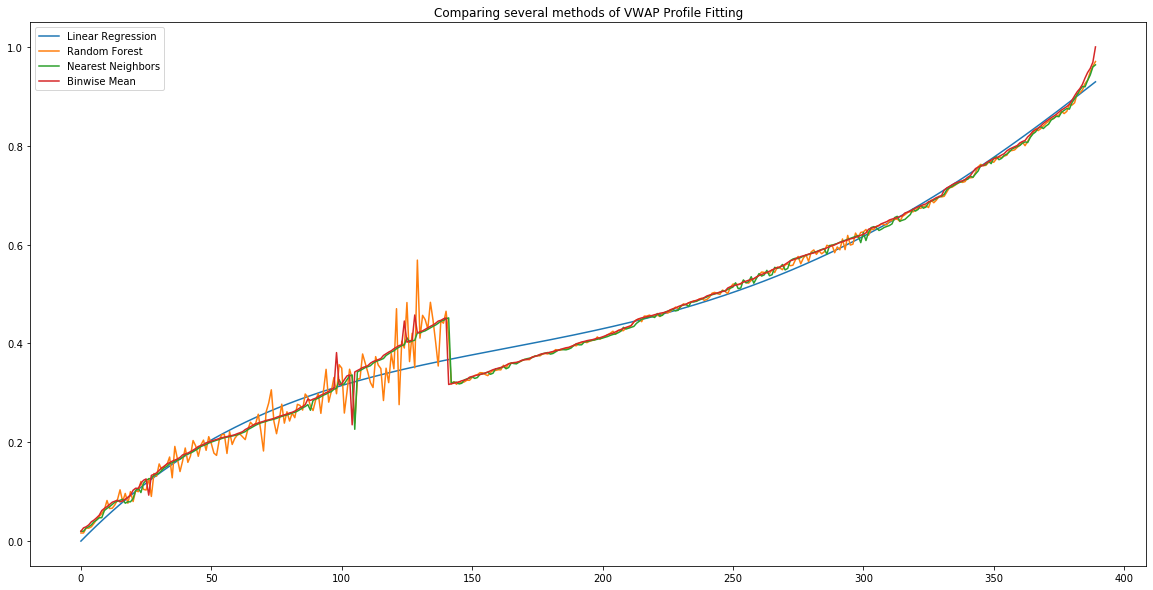

In [13]:
plt.figure(figsize=(20, 10))
plt.title('Comparing several methods of VWAP Profile Fitting')
plt.plot(bins, target_pct_regr, label='Linear Regression')
plt.plot(bins, target_pct_rf, label='Random Forest')
plt.plot(bins, target_pct_nb, label='Nearest Neighbors')
plt.plot(bins, target_pct_mean, label='Binwise Mean')
plt.legend()

### VWAP in a single day

In [14]:
dateList = sorted(list(set(data.index.strftime('%Y-%m-%d').values)))
dateList

['2019-09-24', '2019-09-25', '2019-09-26', '2019-09-27', '2019-09-30']

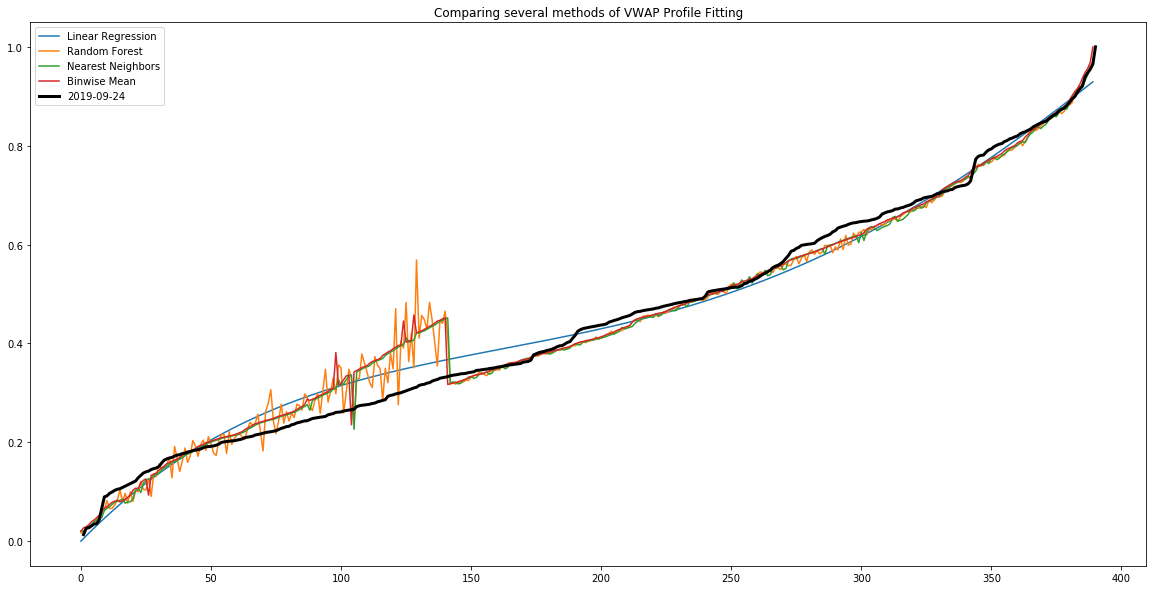

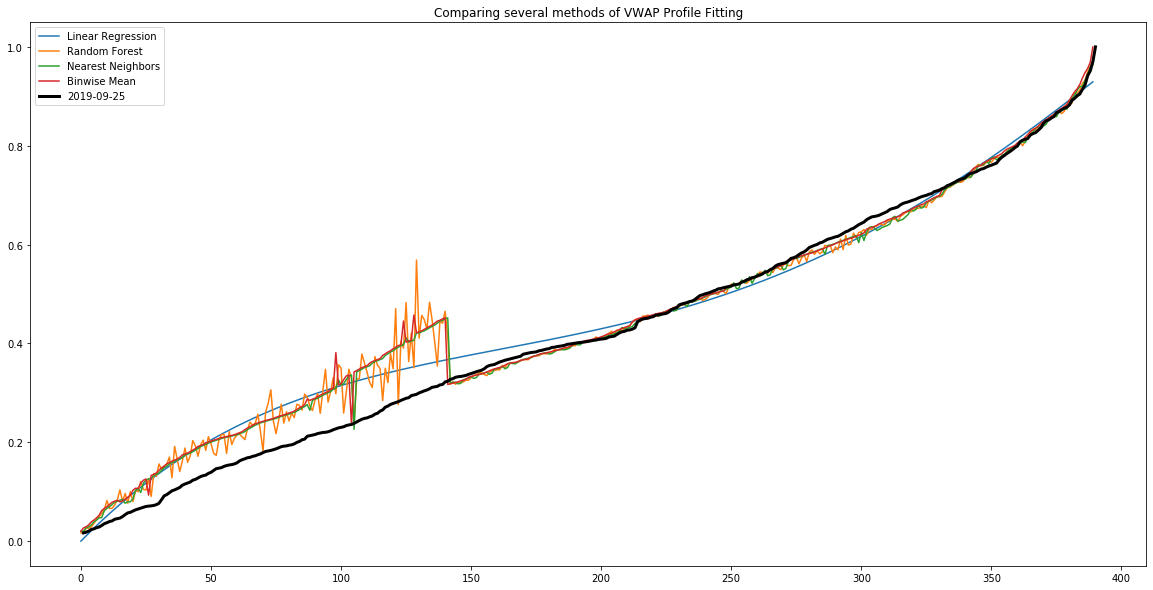

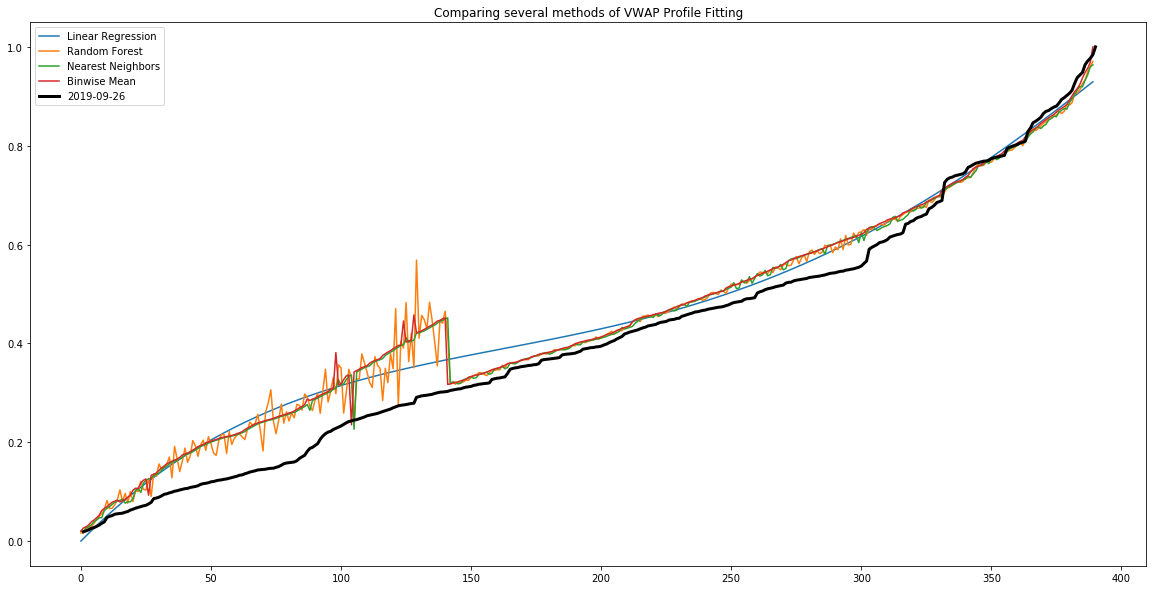

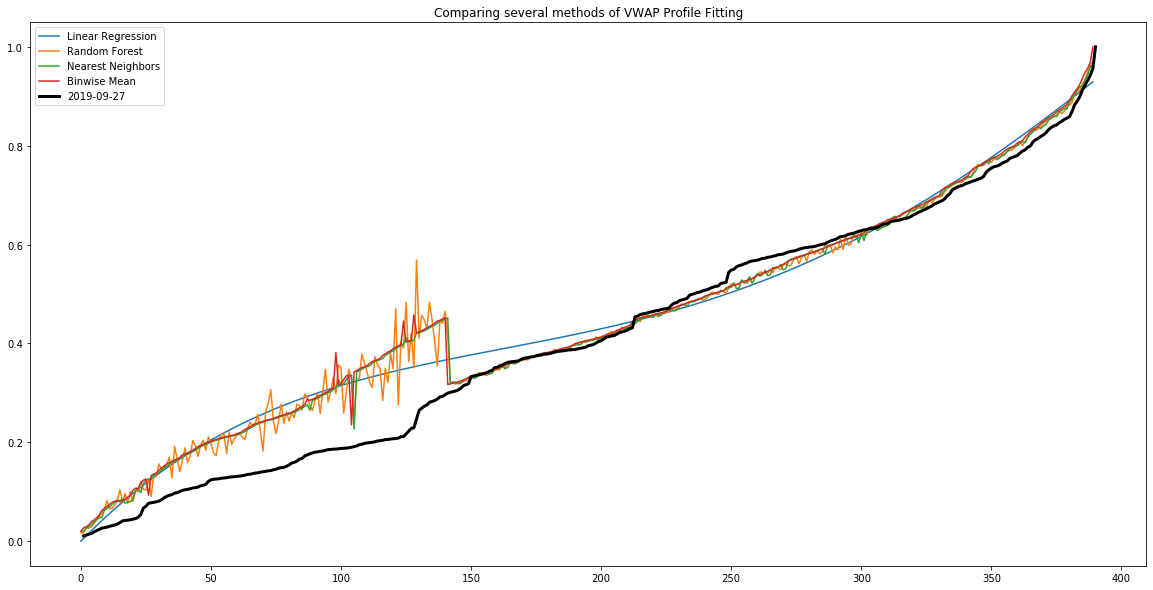

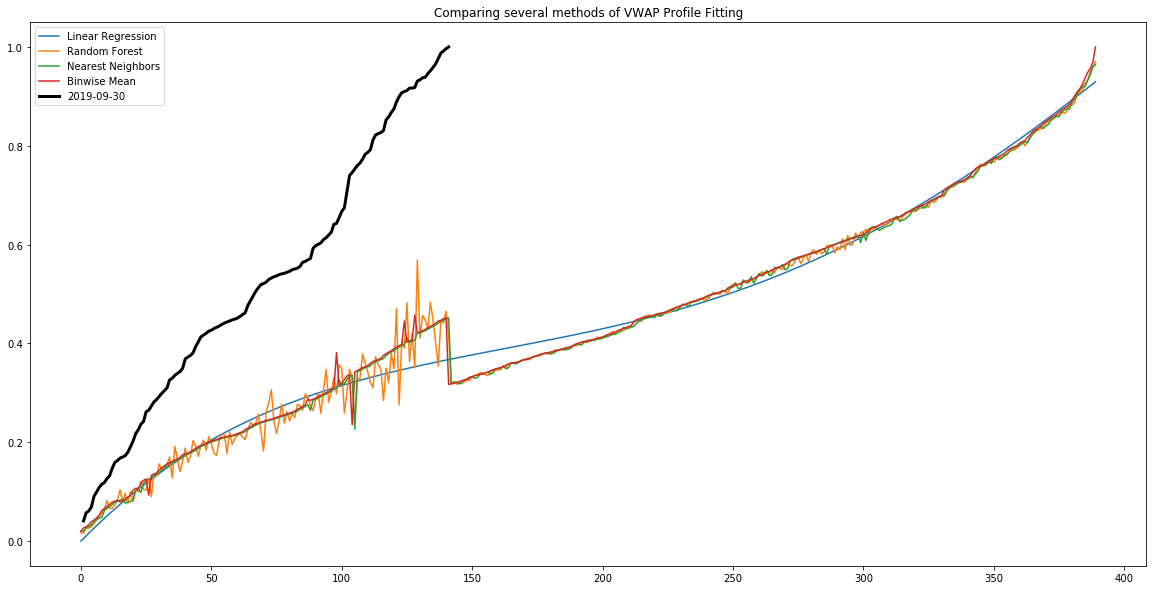

In [15]:
for d in dateList:
    one_day = data[ d ][['acc_perc', 'minute_bars']].reset_index(drop=True)    
    
    plt.figure(figsize=(20, 10))
    plt.title('Comparing several methods of VWAP Profile Fitting')
    plt.plot(bins, target_pct_regr, label='Linear Regression')
    plt.plot(bins, target_pct_rf, label='Random Forest')
    plt.plot(bins, target_pct_nb, label='Nearest Neighbors')
    plt.plot(bins, target_pct_mean, label='Binwise Mean')
    plt.plot(one_day['minute_bars'], one_day['acc_perc'], label=d, linewidth=3, color='black')
    plt.legend()
    plt.show()

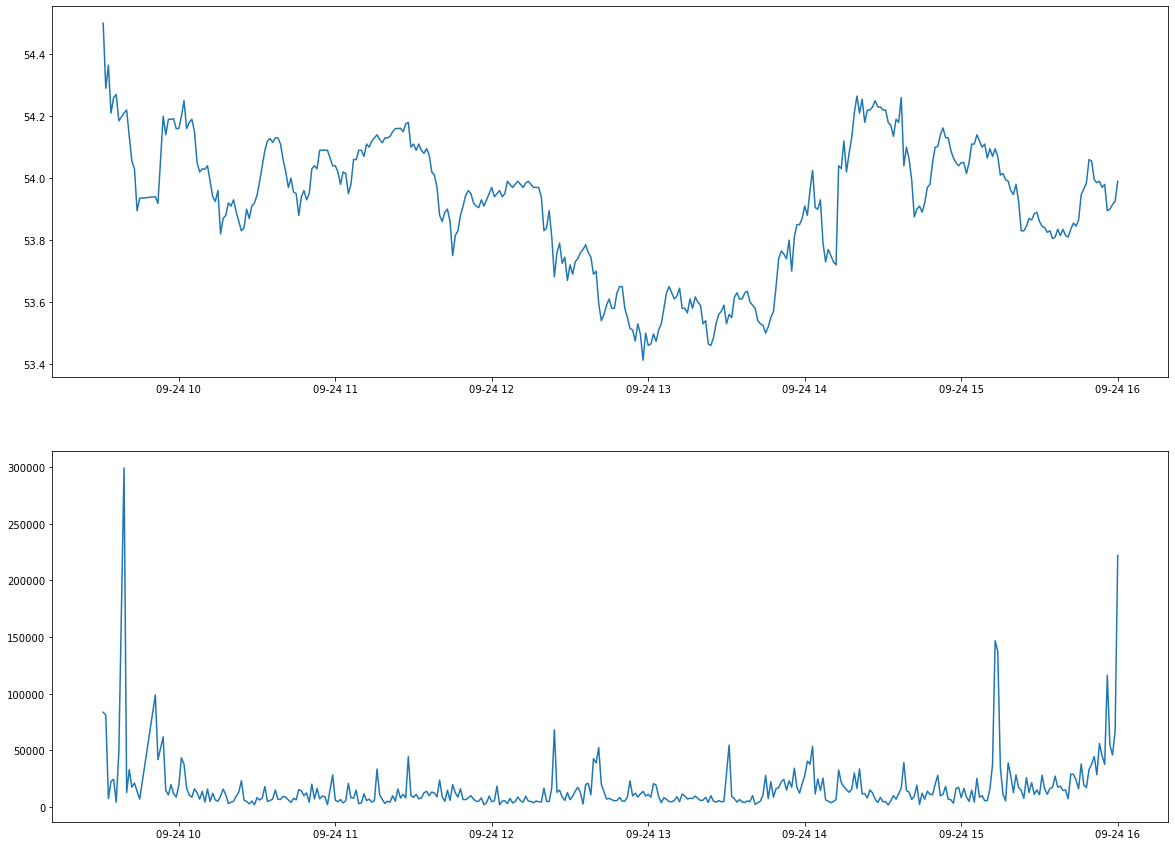

In [16]:
single_date = '2019-09-24'

fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(data[single_date]['close'])
ax[1].plot(data[single_date]['volume'])
plt.show()

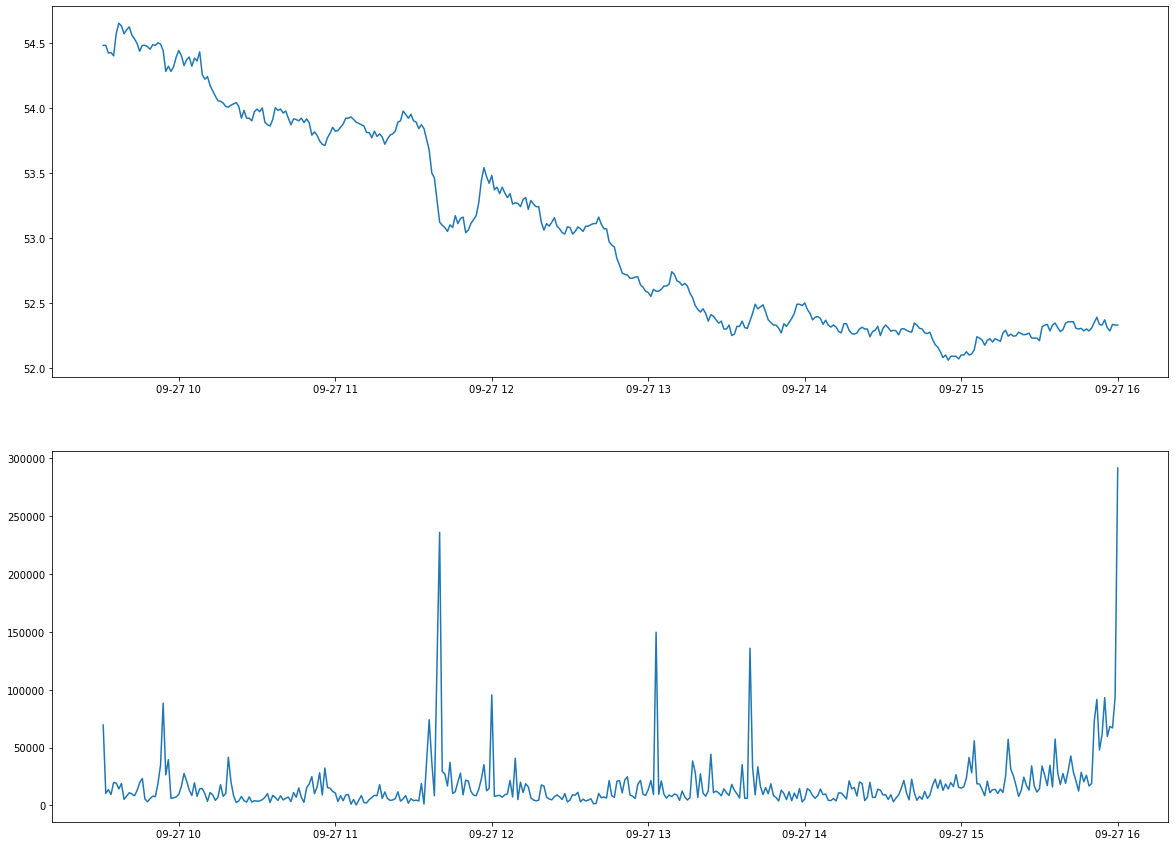

In [17]:
single_date = '2019-09-27'

fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(data[single_date]['close'])
ax[1].plot(data[single_date]['volume'])
plt.show()

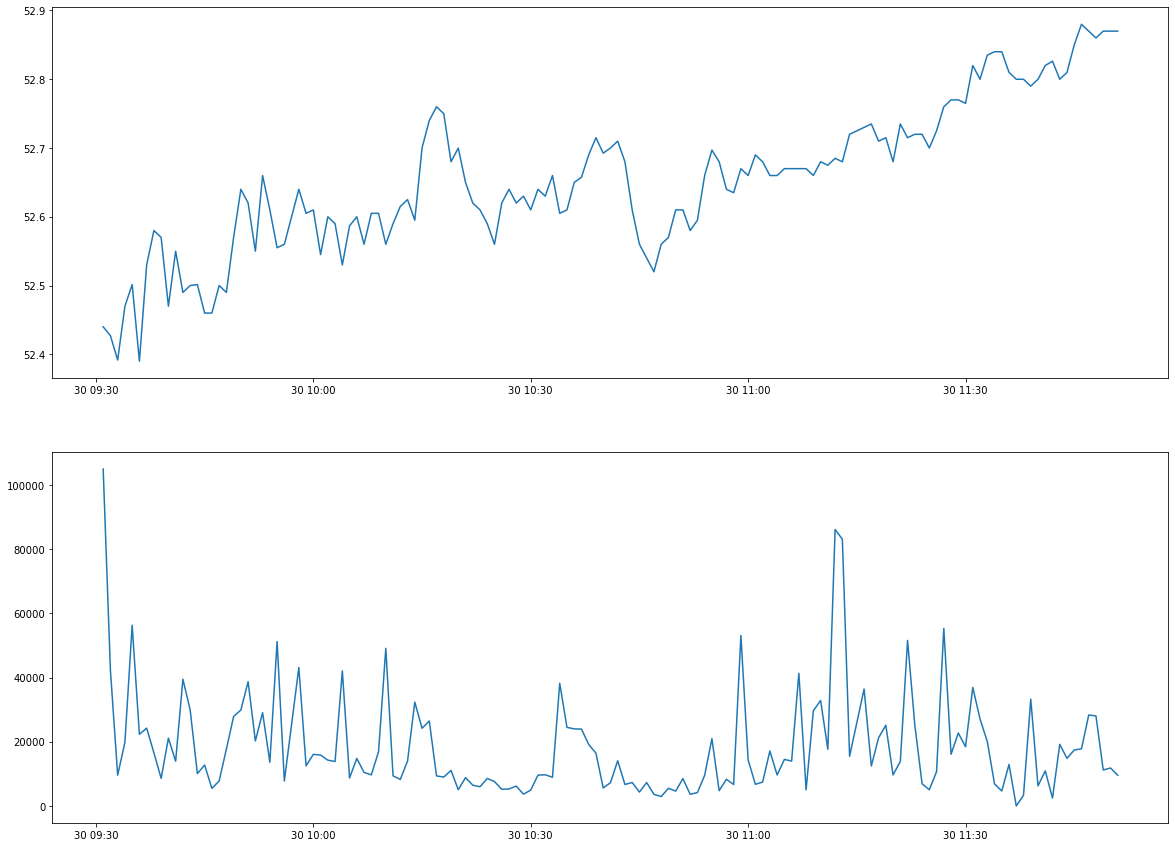

In [18]:
single_date = '2019-09-30'

fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(data[single_date]['close'])
ax[1].plot(data[single_date]['volume'])
plt.show()